In [1]:
# import package
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import random
import copy
import pickle
import bisect

from zipfile import ZipFile
import os
import math
from datetime import *
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, SelectKBest


# load tools
sys.path.append("../tool/")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from imp import reload
import preprocess
import evaluation
import buildmodel

In [3]:
# load the data
raw_train_data = preprocess.load_data("../data/rossmann_store_sales/", "train.csv", 
                       dtype={"StateHoliday":"category",
                             "SchoolHoliday":"uint8",
                             "Promo":"uint8",
                             "Promo2":"category"},
                       converters={"Date":lambda x: pd.to_datetime(x, errors="raise")})

raw_store_data = preprocess.load_data("../data/rossmann_store_sales/", "store.csv")

raw_test_data = preprocess.load_data("../data/rossmann_store_sales/", "test.csv",
                     dtype={"StateHoliday":"category",
                             "SchoolHoliday":"uint8",
                             "Promo":"uint8",
                             "Promo2":"category"},
                       converters={"Date":lambda x: pd.to_datetime(x, errors="raise")})

predict_template = preprocess.load_data("../data/rossmann_store_sales/", "sample_submission.csv")

### preprocess data

对数据进行处理，分别获取到具有重复信息的features—— dumplicate_features，另外获取到了创建的新 features ——new_features

In [4]:
all_data, dulicate_features = preprocess.collect_data(raw_train_data.copy(), raw_test_data.copy(), raw_store_data.copy())

../tool\preprocess.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_data["StateHoliday"] = train_data.loc[:, "StateHoliday"].map(state_holiday)


In [5]:
new_all_data, new_features = preprocess.extend_features(all_data.copy())

### 建立模型
需要先从特征选择开始，之后尝试调整参数

In [10]:
# splite the train data into train_data and validate_data
Xtrain, Xvalidate, ytrain, yvalidate = train_test_split(new_all_data.query("Tag=='train'").copy(), 
                                                        new_all_data.query("Tag=='train'").copy()["SalesByLog"], 
                                                        test_size=0.35, random_state=42,
                                                       shuffle=True)
Xtest = new_all_data.query("Tag=='test'").copy()

In [11]:
Xtrain.SalesByLog.fillna(0, inplace=True)
Xvalidate.SalesByLog.fillna(0, inplace=True)

## 基本训练

In [ ]:
new_features_copy = ["AvgSales", "AvgCustomers", "AvgSalesPerCustomers", "MedianCustomers",
    "HolidayThisWeek", "HolidayNextWeek", "HolidayLastWeek", "AvgSalesInDayOfWeek",
    "MedianSalesInDayOfWeek", "AvgCustsInDayOfWeek", "MedianCustsInDayOfWeek"]

In [ ]:
dtrain = buildmodel.xgb_dmatrix(Xtrain, basic_features+new_features_copy, "SalesByLog", missing=np.nan)
dvalidate = buildmodel.xgb_dmatrix(Xvalidate, basic_features+new_features_copy, "SalesByLog", missing=np.nan)
dtest = xgb.DMatrix(Xtest[basic_features+new_features_copy])

In [ ]:
params = {
    "objective": "reg:linear",
    "eta":.03,
    "max_depth":5,
    "subsample":.9,
    "colsample_bytree":.5,
    "silent":1,
    "seed":42
}

In [ ]:
evallist = [(dvalidate, "eval"), (dtrain, "train")]
round2_model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=2500, evals=evallist,
                                          early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=500)

In [ ]:
evaluation.vis_features_score(round2_model,color_up="g", color_mid="r", color_down="blue", percent_up=.75, percent_down=.25, figsize=(12, 10))

In [12]:
features = ['Open',
 'Assortment_a',
 'Assortment_b',
 'CompetitionDistance',
 'CompetitionOpenMonths',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'InPromo2',
 'OpenDayOfMonth',
 'OpenDayOfYear',
 'OpenMonth',
 'OpenWeekOfYear',
 'OpenYear',
 'Promo',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'SchoolHoliday',
 'StateHoliday_Public',
 'Store',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'AvgSales',
 'AvgCustomers',
 'AvgSalesPerCustomers',
 'MedianCustomers',
 'HolidayThisWeek',
 'HolidayNextWeek',
 'HolidayLastWeek',
 'AvgSalesInDayOfWeek',
 'MedianSalesInDayOfWeek',
 'AvgCustsInDayOfWeek',
 'MedianCustsInDayOfWeek']

In [ ]:
params = {'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'silent': 1,
     'seed': 1301,
    "lambda": .2,
         }


dtrain = buildmodel.xgb_dmatrix(Xtrain, features, "SalesByLog", missing=np.nan)
dvalidate = buildmodel.xgb_dmatrix(Xvalidate, features, "SalesByLog", missing=np.nan)
dtest = xgb.DMatrix(Xtest[features])

evallist = [(dvalidate, "eval"), (dtrain, "train")]

In [ ]:
model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=2500, 
                                   evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=500)

## 再一次筛选训练参数
主要针对的是 max_depth, sumsample, colsample_bytree

In [12]:
params = {'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'silent': 1,
     'seed': 1301,
    "lambda": .2,
         }


dtrain = buildmodel.xgb_dmatrix(Xtrain, features, "SalesByLog", missing=np.nan)
dvalidate = buildmodel.xgb_dmatrix(Xvalidate, features, "SalesByLog", missing=np.nan)
dtest = xgb.DMatrix(Xtest[features])

evallist = [(dvalidate, "eval"), (dtrain, "train")]

In [ ]:
#  筛选树形结构参数
tree_params = []
for md in range(3, 11):
    for ss in range(6, 11):
        for colst in range(5, 11):
            params["max_depth"] = md
            params["subsample"] = ss / 10
            params["colsample_bytree"] = colst / 10
            
            print("The max_depth is %f, subsample is %f,colsample_bytree is %f.\n" % (md, ss, colst))
            model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=2500, 
                                   evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=1250)
            validate_score = evaluation.rmspe(yvalidate, model.predict(dvalidate))
            tree_params.append((copy.deepcopy(params), validate_score))
            
            print("{0:=<60}".format("Current train is done!"))

### 目前已经跑到的参数
The max_depth is 10.000000, subsample is 0.6,colsample_bytree is 0.7，后续需要继续跑下面的参数，增加了lambda 参数

In [13]:
params = {'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 6,
    'subsample': 0.6,
    'colsample_bytree': 0.7,
    'silent': 1,
     'seed': 1301,
    "lambda": .2,
         }

In [14]:
tree_params_second = []
with open("../output/model/tree_params_second001.pickle", "rb") as file:
    tree_params_second = pickle.load(file)

In [15]:
for md in range(11, 13):
    for ss in range(6, 11,2):
        for colst in range(5, 11, 2):
            for lmd in [0.2, .6, .8]:
                    
                    params["max_depth"] = md
                    params["subsample"] = ss / 10
                    params["colsample_bytree"] = colst / 10
                    params["lambda"] = lmd
                    params["gamma"] = 0

                    print("The max_depth is %f, subsample is %f,colsample_bytree is %f, lambda is %f.\n" % (md, ss/10, colst/10, lmd))

                    model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=2000, 
                                           evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=1000)
                    validate_score = evaluation.rmspe(yvalidate, model.predict(dvalidate))
                    tree_params_second.append((copy.deepcopy(params), validate_score))
                    
                    predict_values = model.predict(dtest)
                    predict_csv = evaluation.get_result(predict_values, Xtest, 
                                                        "../output/prediction/test/", "{0}_{1}_{2}{3}.csv".format(md, ss, colst, lmd))

                    print("="*60+"{0:=<60}".format("Current train is done!"))

The max_depth is 11.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.200000.

[0]	eval-rmse:8.18591	train-rmse:8.18609	eval-RMSPE:14.0436	train-RMSPE:14.0437
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.09656	train-rmse:0.089234	eval-RMSPE:0.011185	train-RMSPE:0.010333
[1999]	eval-rmse:0.091027	train-rmse:0.079398	eval-RMSPE:0.010554	train-RMSPE:0.0092
============================================================Current train is done!======================================
The max_depth is 11.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.600000.

[0]	eval-rmse:8.18592	train-rmse:8.1861	eval-RMSPE:14.0438	train-RMSPE:14.0439
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.097206	train-rmse:0.090686	eval-

Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.096619	train-rmse:0.089732	eval-RMSPE:0.011191	train-RMSPE:0.010387
[1999]	eval-rmse:0.090694	train-rmse:0.078941	eval-RMSPE:0.010516	train-RMSPE:0.009149
============================================================Current train is done!======================================
The max_depth is 11.000000, subsample is 0.800000,colsample_bytree is 0.700000, lambda is 0.800000.

[0]	eval-rmse:8.18592	train-rmse:8.1861	eval-RMSPE:14.0437	train-RMSPE:14.0438
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.096738	train-rmse:0.090094	eval-RMSPE:0.011204	train-RMSPE:0.010429
[1999]	eval-rmse:0.090779	train-rmse:0.079273	eval-RMSPE:0.010526	train-RMSPE:0.009186
=======================================================

[1000]	eval-rmse:0.09726	train-rmse:0.090315	eval-RMSPE:0.011262	train-RMSPE:0.010447
[1999]	eval-rmse:0.091416	train-rmse:0.079702	eval-RMSPE:0.010601	train-RMSPE:0.009241
============================================================Current train is done!======================================
The max_depth is 12.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.200000.

[0]	eval-rmse:8.18591	train-rmse:8.18609	eval-RMSPE:14.0436	train-RMSPE:14.0437
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.094108	train-rmse:0.083684	eval-RMSPE:0.010905	train-RMSPE:0.009697
[1999]	eval-rmse:0.089141	train-rmse:0.073088	eval-RMSPE:0.01034	train-RMSPE:0.008476
============================================================Current train is done!======================================
The max_depth is 12.000000, subsample is 0.600000,colsample_bytree is 0.500000, lam

============================================================Current train is done!======================================
The max_depth is 12.000000, subsample is 0.800000,colsample_bytree is 0.700000, lambda is 0.600000.

[0]	eval-rmse:8.18591	train-rmse:8.1861	eval-RMSPE:14.0436	train-RMSPE:14.0437
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.093842	train-rmse:0.08385	eval-RMSPE:0.010874	train-RMSPE:0.009714
[1999]	eval-rmse:0.088633	train-rmse:0.072268	eval-RMSPE:0.010282	train-RMSPE:0.008382
============================================================Current train is done!======================================
The max_depth is 12.000000, subsample is 0.800000,colsample_bytree is 0.700000, lambda is 0.800000.

[0]	eval-rmse:8.18592	train-rmse:8.1861	eval-RMSPE:14.0437	train-RMSPE:14.0438
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early 

[0]	eval-rmse:8.18591	train-rmse:8.1861	eval-RMSPE:14.0436	train-RMSPE:14.0437
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.094744	train-rmse:0.084698	eval-RMSPE:0.010976	train-RMSPE:0.009806
[1999]	eval-rmse:0.089354	train-rmse:0.07304	eval-RMSPE:0.010367	train-RMSPE:0.008476
============================================================Current train is done!======================================


### colsample_tree 参数
建议选择 0.5，不论哪个模型都是在 0.5 的时候要优异很多

In [16]:
test_value = tree_params_second[0][1]
for i in tree_params_second:
    if test_value > i[1]:
        test_value = i[1]
        test_params = i[0]
print(test_value, test_params)   
model = buildmodel.xgb_naive_model(test_params, dtrain, num_boost_round=12000, 
                                           evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=2000)

0.01033226092737346 {'objective': 'reg:linear', 'booster': 'gbtree', 'eta': 0.01, 'max_depth': 12, 'min_child_weight': 6, 'subsample': 1.0, 'colsample_bytree': 0.5, 'silent': 1, 'seed': 1301, 'lambda': 0.2, 'gamma': 0}
[0]	eval-rmse:8.18591	train-rmse:8.18609	eval-RMSPE:14.0435	train-RMSPE:14.0436
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[2000]	eval-rmse:0.087946	train-rmse:0.069199	eval-RMSPE:0.010205	train-RMSPE:0.008038
[4000]	eval-rmse:0.085631	train-rmse:0.059318	eval-RMSPE:0.009944	train-RMSPE:0.006901
[6000]	eval-rmse:0.084801	train-rmse:0.052614	eval-RMSPE:0.009852	train-RMSPE:0.006124
[8000]	eval-rmse:0.084525	train-rmse:0.047519	eval-RMSPE:0.009822	train-RMSPE:0.005531
[10000]	eval-rmse:0.08442	train-rmse:0.042979	eval-RMSPE:0.009812	train-RMSPE:0.005003
[11999]	eval-rmse:0.08443	train-rmse:0.039443	eval-RMSPE:0.009814	train-RMSPE:0.004592


In [22]:
predict_values = model.predict(dtest)
predict_csv = evaluation.get_result(predict_values, Xtest, 
                                    "../output/prediction/test/", "secondparams_12000round.csv")

In [31]:
tree_params_second.sort(key=lambda x: x[1])

In [59]:
tree_params_second[26][0]

{'objective': 'reg:linear',
 'booster': 'gbtree',
 'eta': 0.01,
 'max_depth': 12,
 'min_child_weight': 6,
 'subsample': 0.6,
 'colsample_bytree': 0.5,
 'silent': 1,
 'seed': 1301,
 'lambda': 0.8,
 'gamma': 0}

In [60]:
model = buildmodel.xgb_naive_model(tree_params_second[26][0], dtrain, num_boost_round=12000, 
                                           evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=2000)
predict_values = model.predict(dtest)
predict_csv = evaluation.get_result(predict_values, Xtest, 
                                    "../output/prediction/test/", "12_6_50.8secondparams_12000round.csv")

[0]	eval-rmse:8.18592	train-rmse:8.1861	eval-RMSPE:14.0439	train-RMSPE:14.044
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[2000]	eval-rmse:0.089492	train-rmse:0.074956	eval-RMSPE:0.010379	train-RMSPE:0.008691
[4000]	eval-rmse:0.08642	train-rmse:0.063307	eval-RMSPE:0.010033	train-RMSPE:0.007342
[6000]	eval-rmse:0.08562	train-rmse:0.055462	eval-RMSPE:0.009947	train-RMSPE:0.006433
[8000]	eval-rmse:0.085491	train-rmse:0.049277	eval-RMSPE:0.009936	train-RMSPE:0.005716
[10000]	eval-rmse:0.085609	train-rmse:0.044142	eval-RMSPE:0.009952	train-RMSPE:0.005118
[11999]	eval-rmse:0.085857	train-rmse:0.039807	eval-RMSPE:0.009983	train-RMSPE:0.004613


## 增加 depth

In [61]:
for md in range(13, 16):
    for ss in [6, 8]:
        for colst in [4, 5, 6]:
            for lmd in [0.1, 0.2]:
                    
                    params["max_depth"] = md
                    params["subsample"] = ss / 10
                    params["colsample_bytree"] = colst / 10
                    params["lambda"] = lmd
                    params["gamma"] = 0

                    print("The max_depth is %f, subsample is %f,colsample_bytree is %f, lambda is %f.\n" % (md, ss/10, colst/10, lmd))

                    model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=2000, 
                                           evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=1000)
                    validate_score = evaluation.rmspe(yvalidate, model.predict(dvalidate))
                    tree_params_second.append((copy.deepcopy(params), validate_score))
                    
                    predict_values = model.predict(dtest)
                    predict_csv = evaluation.get_result(predict_values, Xtest, 
                                                        "../output/prediction/test/", "{0}_{1}_{2}{3}.csv".format(md, ss, colst, lmd))

                    print("="*60+"{0:=<60}".format("Current train is done!"))

The max_depth is 13.000000, subsample is 0.600000,colsample_bytree is 0.400000, lambda is 0.100000.

[0]	eval-rmse:8.18598	train-rmse:8.18617	eval-RMSPE:14.0465	train-RMSPE:14.0467
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.09305	train-rmse:0.078854	eval-RMSPE:0.010784	train-RMSPE:0.009144
[1999]	eval-rmse:0.088341	train-rmse:0.067264	eval-RMSPE:0.010249	train-RMSPE:0.007809
============================================================Current train is done!======================================
The max_depth is 13.000000, subsample is 0.600000,colsample_bytree is 0.400000, lambda is 0.200000.

[0]	eval-rmse:8.18599	train-rmse:8.18618	eval-RMSPE:14.0469	train-RMSPE:14.0471
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.093235	train-rmse:0.079893	ev

[0]	eval-rmse:8.18599	train-rmse:8.18617	eval-RMSPE:14.0467	train-RMSPE:14.0468
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.091703	train-rmse:0.074695	eval-RMSPE:0.010629	train-RMSPE:0.008667
[1999]	eval-rmse:0.087544	train-rmse:0.062215	eval-RMSPE:0.010159	train-RMSPE:0.007229
============================================================Current train is done!======================================
The max_depth is 14.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.100000.

[0]	eval-rmse:8.18591	train-rmse:8.18609	eval-RMSPE:14.0435	train-RMSPE:14.0435
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.090668	train-rmse:0.071877	eval-RMSPE:0.010513	train-RMSPE:0.008345
[1999]	eval-rmse:0.087265	train-rmse:0.060289	eval-RMSPE:0.01

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.089697	train-rmse:0.066691	eval-RMSPE:0.010403	train-RMSPE:0.007751
[1999]	eval-rmse:0.086915	train-rmse:0.054432	eval-RMSPE:0.01009	train-RMSPE:0.006331
============================================================Current train is done!======================================
The max_depth is 15.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.200000.

[0]	eval-rmse:8.18591	train-rmse:8.18609	eval-RMSPE:14.0436	train-RMSPE:14.0437
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.089675	train-rmse:0.067981	eval-RMSPE:0.0104	train-RMSPE:0.007899
[1999]	eval-rmse:0.086749	train-rmse:0.055431	eval-RMSPE:0.010071	train-RMSPE:0.006446
============================================================Current train is done!======================================
The max_depth is 15.0000

In [62]:
with open("../output/model/tree_params_second001.pickle", "wb") as file:
    pickle.dump(tree_params_second, file)

In [63]:
for md in range(16, 19):
    for ss in [6, 8]:
        for colst in [4, 5, 6]:
            for lmd in [0.1, 0.2]:
                    
                    params["max_depth"] = md
                    params["subsample"] = ss / 10
                    params["colsample_bytree"] = colst / 10
                    params["lambda"] = lmd
                    params["gamma"] = 0

                    print("The max_depth is %f, subsample is %f,colsample_bytree is %f, lambda is %f.\n" % (md, ss/10, colst/10, lmd))

                    model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=2000, 
                                           evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=1000)
                    validate_score = evaluation.rmspe(yvalidate, model.predict(dvalidate))
                    tree_params_second.append((copy.deepcopy(params), validate_score))
                    
                    predict_values = model.predict(dtest)
                    predict_csv = evaluation.get_result(predict_values, Xtest, 
                                                        "../output/prediction/test/", "{0}_{1}_{2}{3}.csv".format(md, ss, colst, lmd))

                    print("="*60+"{0:=<60}".format("Current train is done!"))

The max_depth is 16.000000, subsample is 0.600000,colsample_bytree is 0.400000, lambda is 0.100000.

[0]	eval-rmse:8.18597	train-rmse:8.18615	eval-RMSPE:14.0458	train-RMSPE:14.0459
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.089825	train-rmse:0.06365	eval-RMSPE:0.010417	train-RMSPE:0.007403
[1999]	eval-rmse:0.087201	train-rmse:0.050613	eval-RMSPE:0.010123	train-RMSPE:0.005894
============================================================Current train is done!======================================
The max_depth is 16.000000, subsample is 0.600000,colsample_bytree is 0.400000, lambda is 0.200000.

[0]	eval-rmse:8.18599	train-rmse:8.18617	eval-RMSPE:14.0464	train-RMSPE:14.0465
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.089815	train-rmse:0.065098	ev

[0]	eval-rmse:8.18599	train-rmse:8.18617	eval-RMSPE:14.0463	train-RMSPE:14.0464
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.089298	train-rmse:0.060796	eval-RMSPE:0.010357	train-RMSPE:0.007075
[1999]	eval-rmse:0.087036	train-rmse:0.046856	eval-RMSPE:0.010106	train-RMSPE:0.005461
============================================================Current train is done!======================================
The max_depth is 17.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.100000.

[0]	eval-rmse:8.18591	train-rmse:8.18609	eval-RMSPE:14.0435	train-RMSPE:14.0435
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.088659	train-rmse:0.05754	eval-RMSPE:0.010286	train-RMSPE:0.006701
[1999]	eval-rmse:0.086941	train-rmse:0.044258	eval-RMSPE:0.010

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.088484	train-rmse:0.053642	eval-RMSPE:0.010267	train-RMSPE:0.006254
[1999]	eval-rmse:0.087121	train-rmse:0.039894	eval-RMSPE:0.010118	train-RMSPE:0.004653
============================================================Current train is done!======================================
The max_depth is 18.000000, subsample is 0.600000,colsample_bytree is 0.500000, lambda is 0.200000.

[0]	eval-rmse:8.18591	train-rmse:8.18609	eval-RMSPE:14.0436	train-RMSPE:14.0437
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.088284	train-rmse:0.055134	eval-RMSPE:0.010244	train-RMSPE:0.006425
[1999]	eval-rmse:0.086827	train-rmse:0.040862	eval-RMSPE:0.010085	train-RMSPE:0.004766
============================================================Current train is done!======================================
The max_depth is 18.0

In [64]:
# store the parameters and the score
with open("../output/model/tree_params_second001.pickle", "wb") as file:
    pickle.dump(tree_params_second, file)

##  得到评分后重新运行模型

In [15]:
params = {'objective': 'reg:linear',
    'booster': 'gbtree',
    'eta': 0.01,
    'max_depth': 10,
    'min_child_weight': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'silent': 1,
     'seed': 1301,
    "lambda": .2,
         }


dtrain = buildmodel.xgb_dmatrix(Xtrain, features, "SalesByLog", missing=np.nan)
dvalidate = buildmodel.xgb_dmatrix(Xvalidate, features, "SalesByLog", missing=np.nan)
dtest = xgb.DMatrix(Xtest[features])

evallist = [(dvalidate, "eval"), (dtrain, "train")]

In [16]:
# update the parameters
params["max_depth"] = 16
params["subsample"] = 0.6
params["colsample_bytree"] = 0.4
params["lambda"] = 0.2
params["gamma"] = 0

# train the final model
model = buildmodel.xgb_naive_model(params, dtrain, num_boost_round=2000, 
                       evals=evallist,early_stopping_rounds=100, feval=evaluation.rmspe_xgb, verbose_eval=1000)
validate_score = evaluation.rmspe(yvalidate, model.predict(dvalidate))


print("="*60+"{0:=<60}".format("Current train is done!"))

[0]	eval-rmse:8.18599	train-rmse:8.18617	eval-RMSPE:14.0464	train-RMSPE:14.0465
Multiple eval metrics have been passed: 'train-RMSPE' will be used for early stopping.

Will train until train-RMSPE hasn't improved in 100 rounds.
[1000]	eval-rmse:0.089815	train-rmse:0.065098	eval-RMSPE:0.010416	train-RMSPE:0.007568
[1999]	eval-rmse:0.086994	train-rmse:0.051589	eval-RMSPE:0.0101	train-RMSPE:0.006006
============================================================Current train is done!======================================


## 检测模型结果

In [66]:
Xpredict = new_all_data.query("Tag=='train' & Date >= '2015-1-1'").copy()
dpredict = buildmodel.xgb_dmatrix(Xpredict, features, "SalesByLog", missing=np.nan)

In [67]:
validate_value = model.predict(dpredict)
# predict_csv = evaluation.get_result(predict_values, Xtest, 
#                                     "../output/prediction/test/", "{0}_{1}_{2}{3}.csv")

In [74]:
Xpredict["SalesPredicted"] = np.expm1(validate_value)
Xpredict["SalesDifference"] = Xpredict["Sales"] - Xpredict["SalesPredicted"]
Xpredict["RMSPE_score"] = Xpredict["SalesDifference"] / Xpredict["Sales"]

In [69]:
Xpredict.sort_values(by="Date", inplace=True)

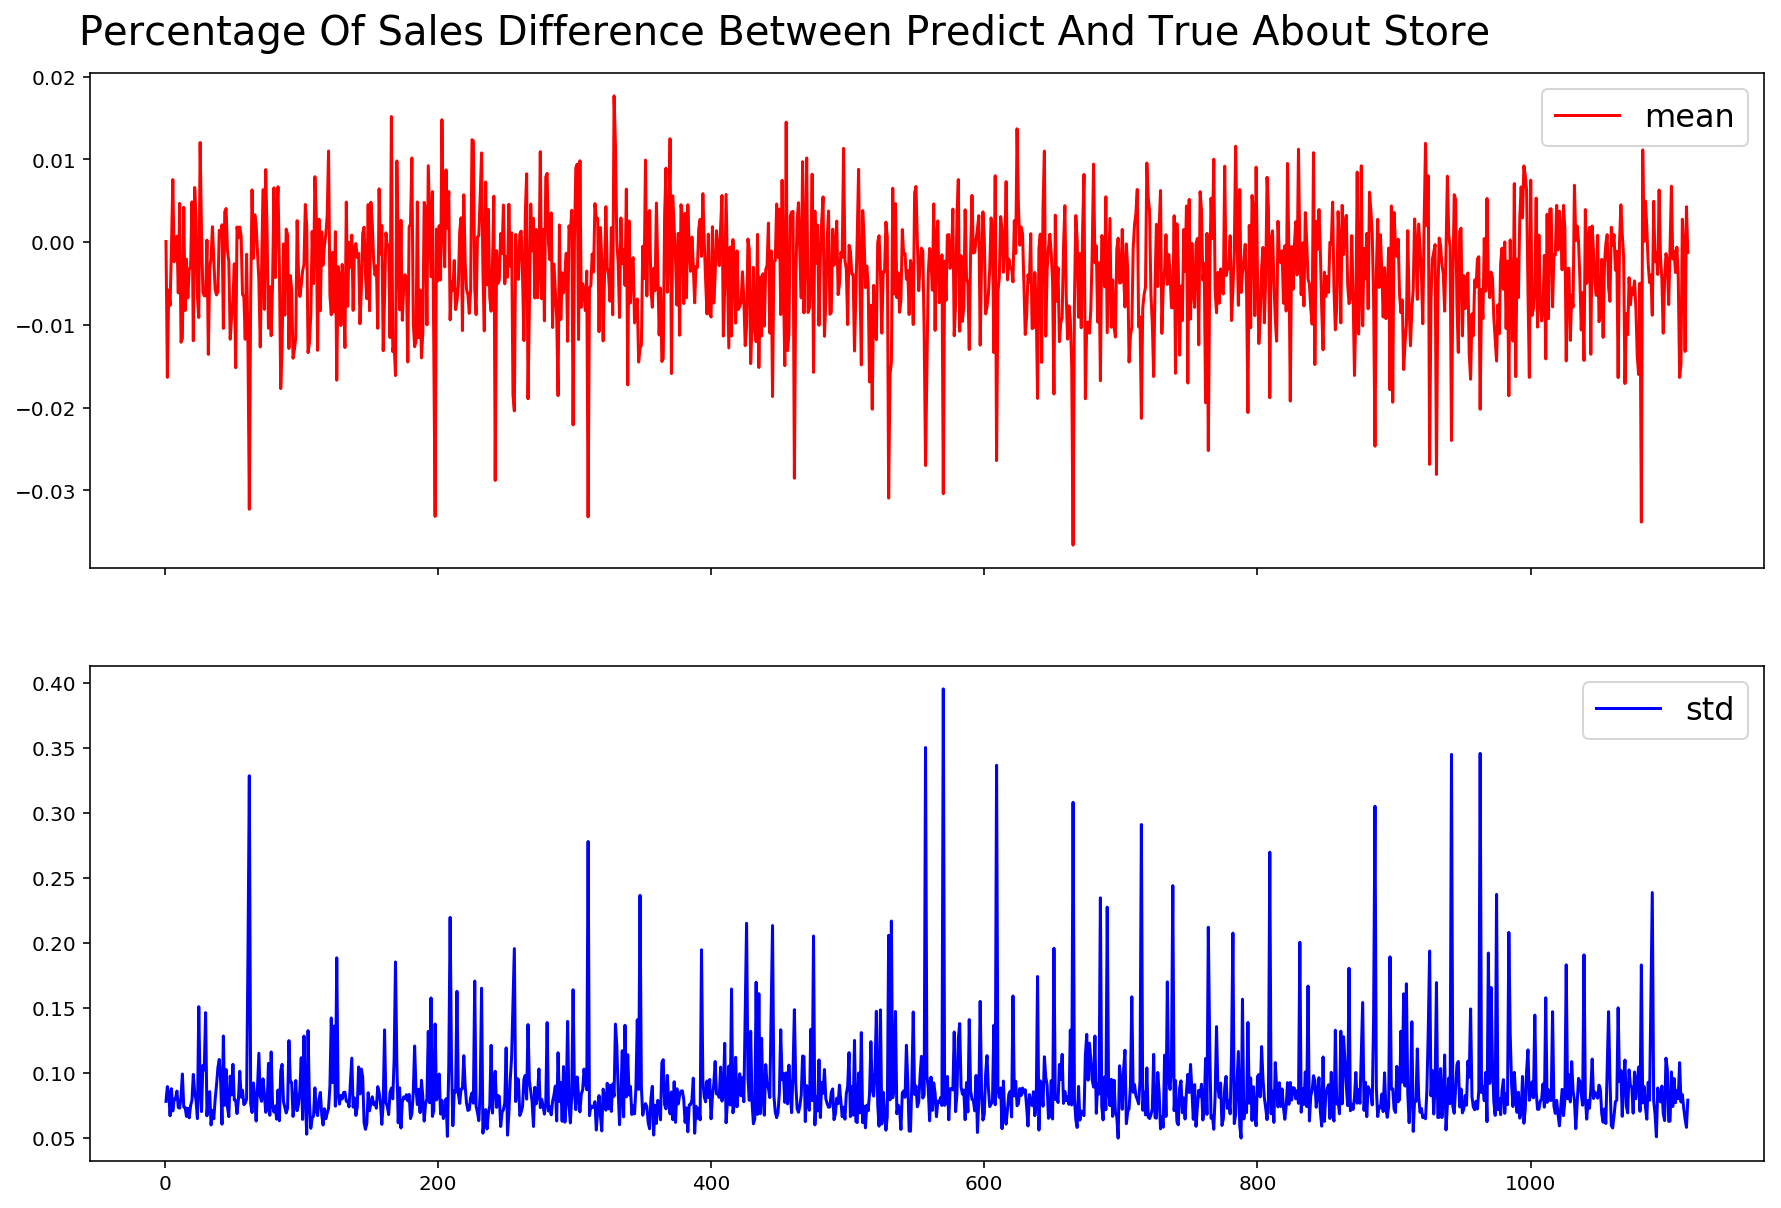

In [156]:
Xvalidate["RMSPE_score"] = Xvalidate["SalesDifference"] / Xvalidate["Sales"]
mean = Xvalidate.groupby("Store").RMSPE_score.mean()
std = Xvalidate.groupby("Store").RMSPE_score.std()
# mean = pd.DataFrame(mean.apply(abs))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

# plt.title("Percentage Of Sales Difference Between Predict And True" )
plot_mean = ax1.plot(mean.index, mean.values, "r")
plot_std = ax2.plot(std.index, std.values, "b")
# ax1.title.draw(pttext.Text(0.5, 1, "Percentage Of Sales Difference Between Predict And True"))
fig.text(0.12, 0.9, "Percentage Of Sales Difference Between Predict And True About Store", fontsize=20)
ax1.legend(["mean"],fontsize=16)
ax2.legend(["std"], fontsize=16)

plt.show()

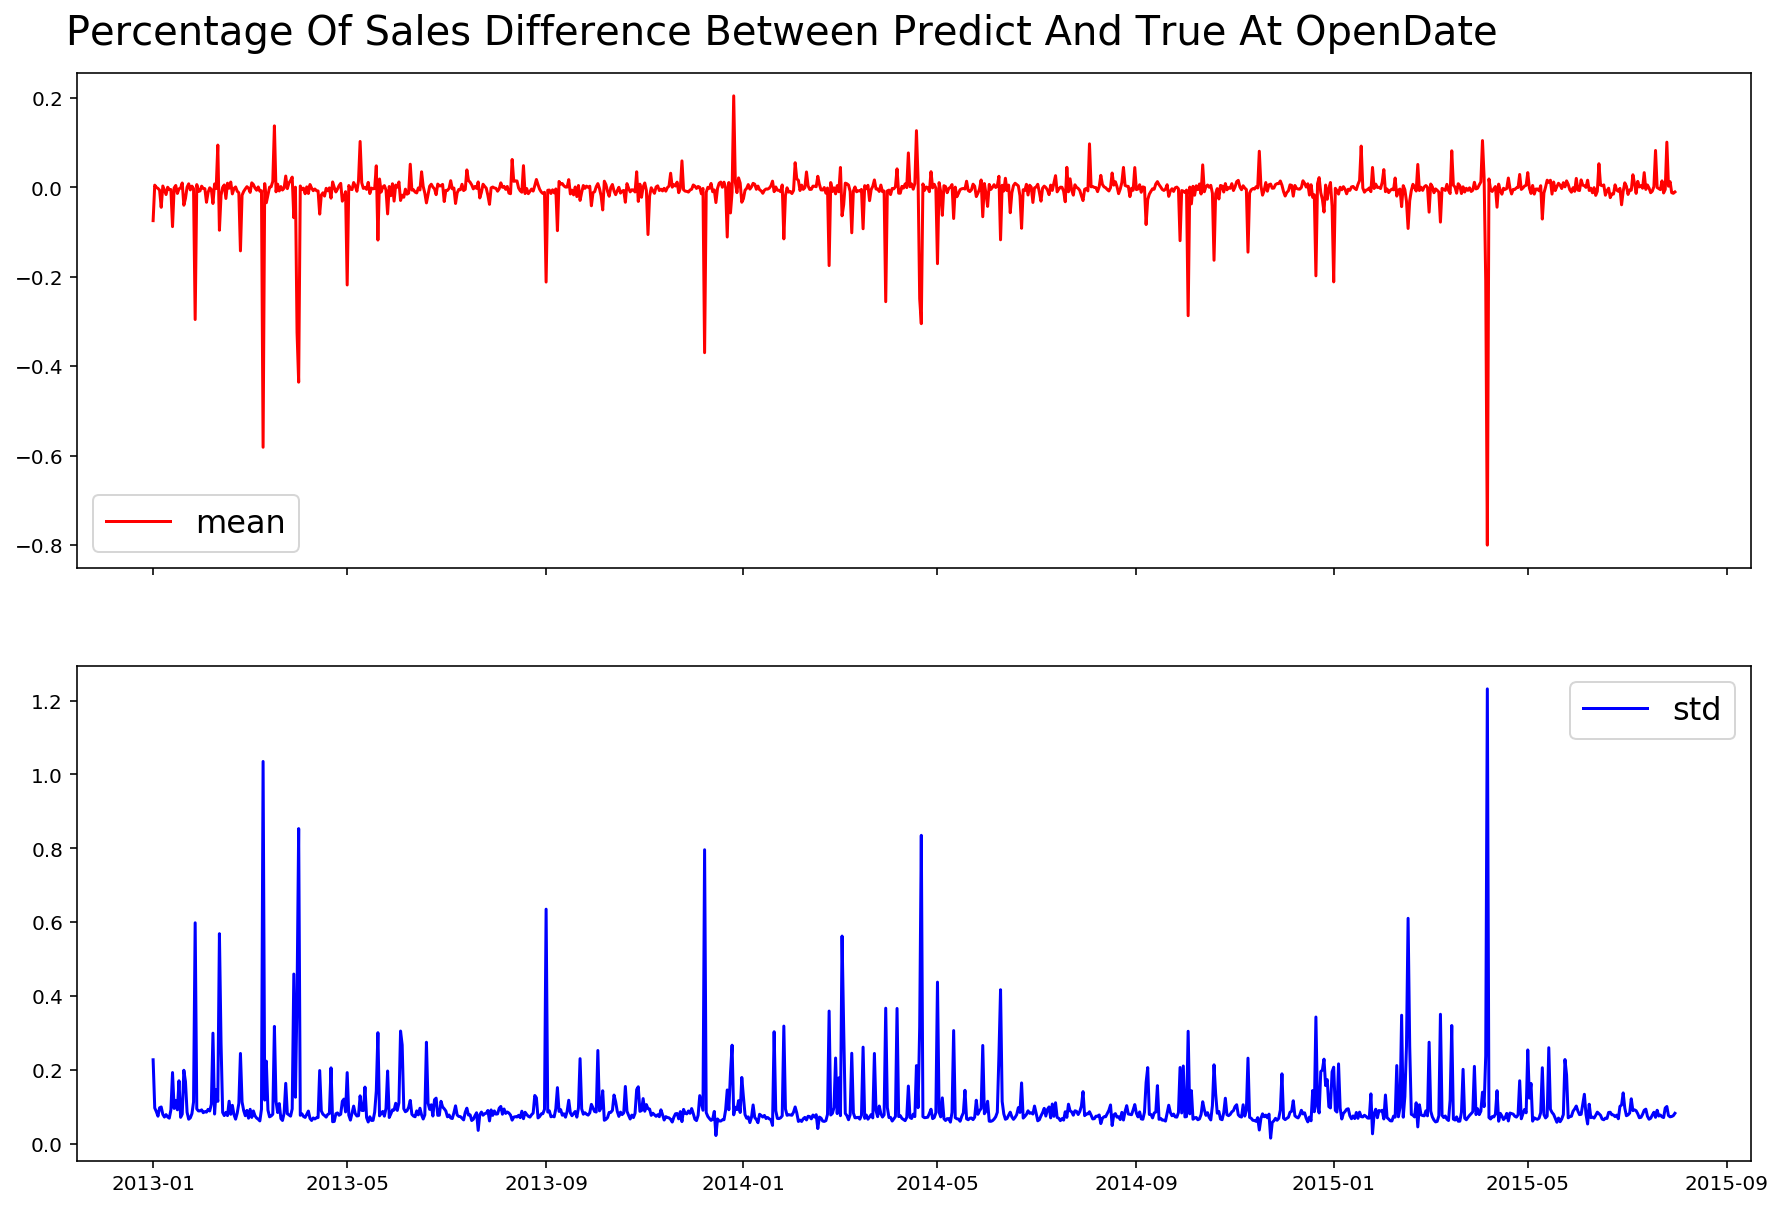

In [158]:
mean = Xvalidate.groupby("Date").RMSPE_score.mean()
std = Xvalidate.groupby("Date").RMSPE_score.std()
# mean = pd.DataFrame(mean.apply(abs))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

# plt.title("Percentage Of Sales Difference Between Predict And True" )
plot_mean = ax1.plot(mean.index, mean.values, "r")
plot_std = ax2.plot(std.index, std.values, "b")
# ax1.title.draw(pttext.Text(0.5, 1, "Percentage Of Sales Difference Between Predict And True"))
fig.text(0.12, 0.9, "Percentage Of Sales Difference Between Predict And True At OpenDate", fontsize=20)
ax1.legend(["mean"],fontsize=16)
ax2.legend(["std"], fontsize=16)

plt.show()

In [162]:
mean = Xvalidate.groupby("Store").RMSPE_score.mean()
std = Xvalidate.groupby("Store").RMSPE_score.std()
mean.idxmax(), std.idxmax()

(329, 570)

In [219]:
store_329 = Xvalidate.query("Store==329 & Date >= '2015-05-01'").copy()

In [220]:
test_1 = store_329[["Date", "Sales"]].copy()
test_1["Type"] = "Real Sales"

test_2 = store_329[["Date", "SalesPredicted"]].copy()
test_2.columns = ["Date", "Sales"]
test_2["Type"] = "Predict Sales"
store_329 = pd.concat([test_1, test_2])
store_329.Date = store_329.Date.dt.strftime("%y-%m-%d")

In [232]:
dateindex = []
for index, dt in enumerate(store_329.Date):
    if index % 4 == 0:
        dateindex.append(dt)


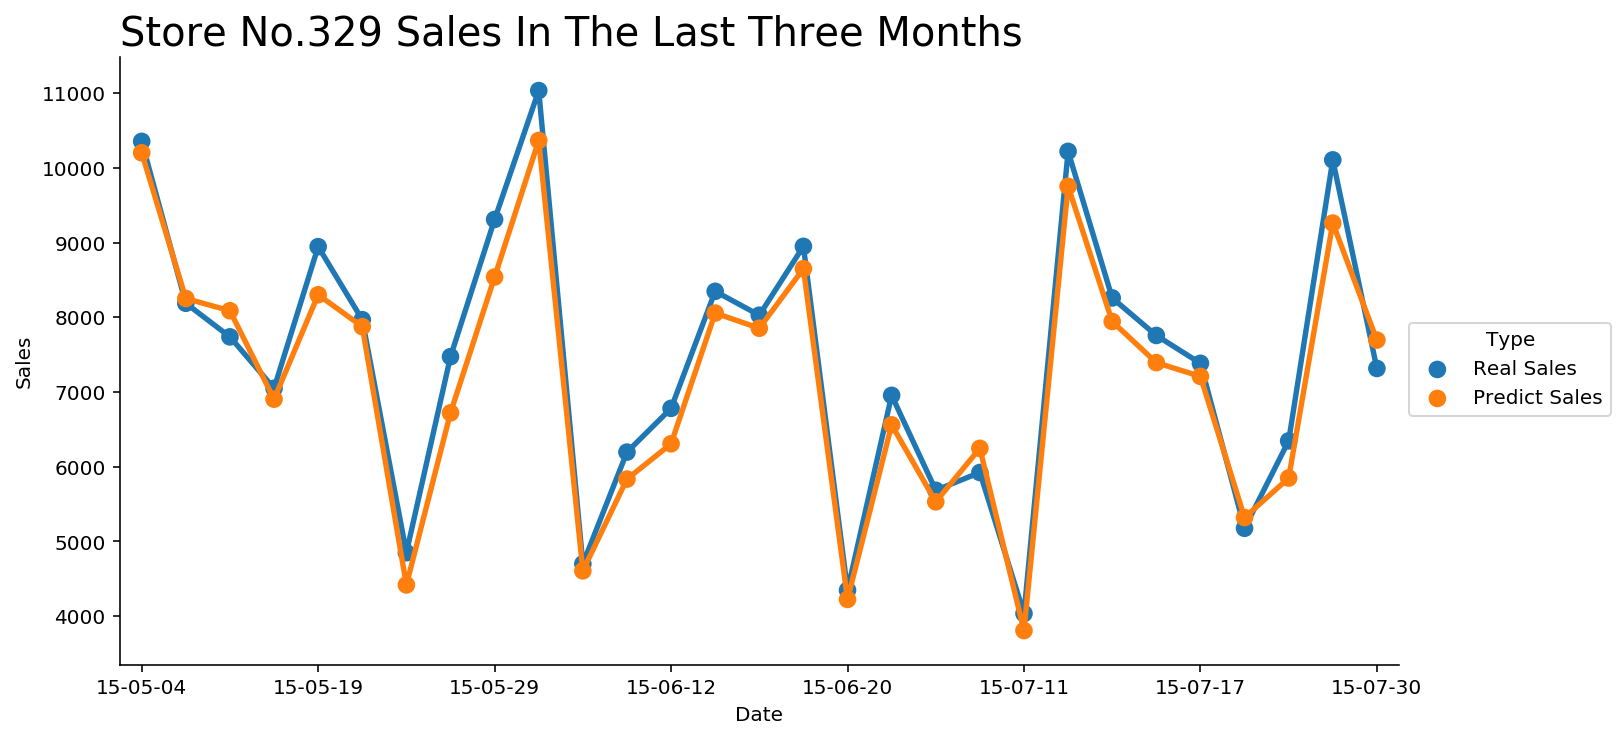

In [235]:
plt.figure(figsize=(15, 7))
g = sns.factorplot(x="Date", y="Sales", hue="Type", data=store_329,size=5,aspect=2)
g.set_axis_labels("Date", "Sales")

# g.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Store No.329 Sales In The Last Three Months", loc="left", fontsize=20)
ax = plt.gca()
ax.set_xticks(range(0, 29, 4))
ax.set_xticklabels(dateindex)
# ax.
plt.show()

In [239]:
store_570 = Xvalidate.query("Store==570 & Date >= '2015-05-01'").copy()
test_1 = store_570[["Date", "Sales"]].copy()
test_1["Type"] = "Real Sales"

test_2 = store_570[["Date", "SalesPredicted"]].copy()
test_2.columns = ["Date", "Sales"]
test_2["Type"] = "Predict Sales"
store_570 = pd.concat([test_1, test_2])
store_570.Date = store_570.Date.dt.strftime("%y-%m-%d")

dateindex = []
for index, dt in enumerate(store_570.Date):
    if index % 4 == 0:
        dateindex.append(dt)


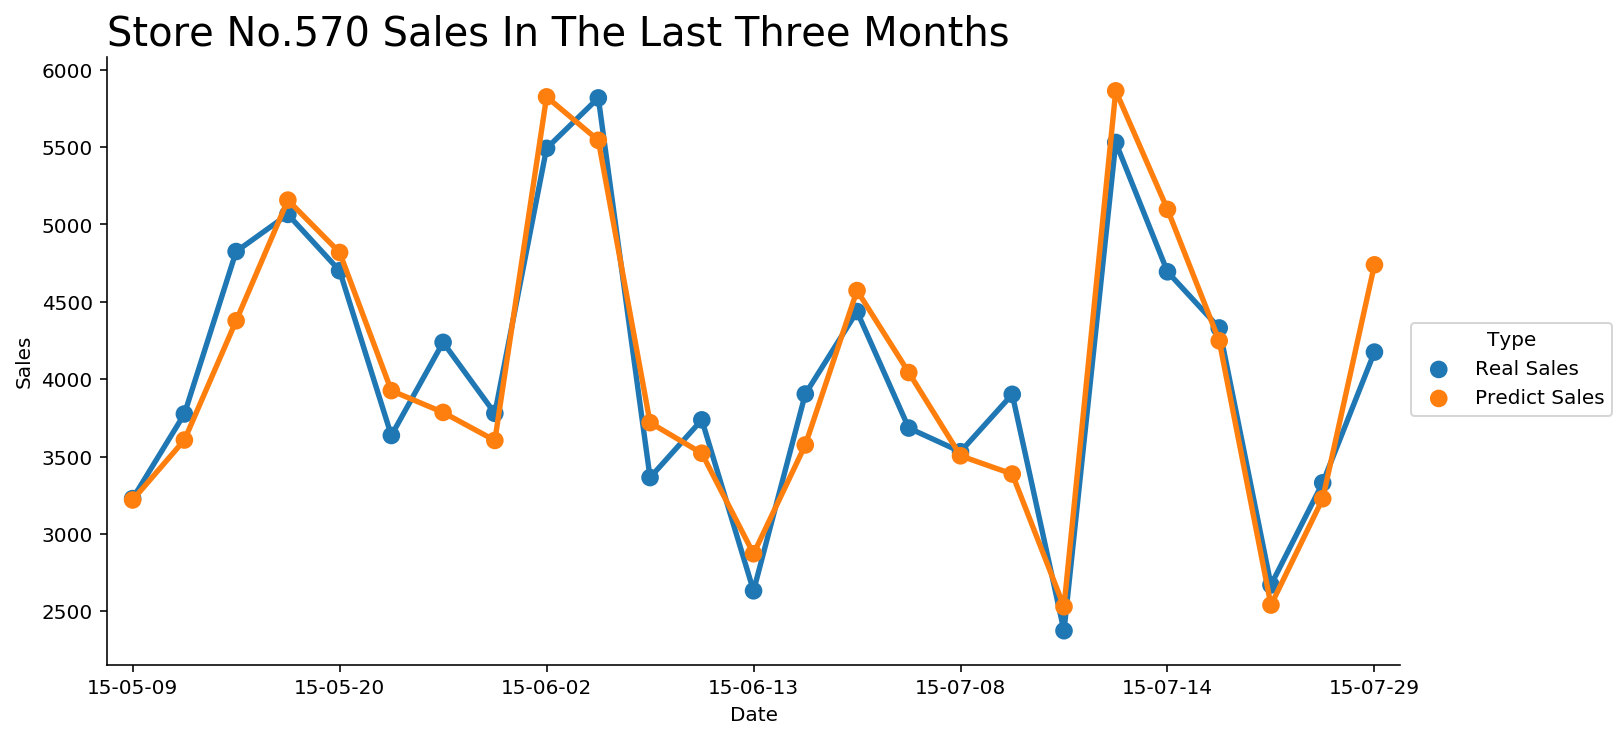

In [243]:
plt.figure(figsize=(15, 7))
g = sns.factorplot(x="Date", y="Sales", hue="Type", data=store_570,size=5,aspect=2)
g.set_axis_labels("Date", "Sales")

# g.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.title("Store No.570 Sales In The Last Three Months", loc="left", fontsize=20)
ax = plt.gca()
ax.set_xticks(range(0, 28, 4))
ax.set_xticklabels(dateindex)
# ax.
plt.show()